In [30]:
pip install tensorflow

  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached libclang-14.0.6-py2.py3-none-win_amd64.whl (14.2 MB)
  Using cached flatbuffers-2.0.7-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached grpcio-1.48.1-cp39-cp39-win_amd64.whl (3.6 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.10.0-py3-none-any.whl (5.9 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp39-cp39-win_amd64.whl (1.5 MB)
  Using cached protobuf-3.19.5-cp39-cp39-win_amd64.whl (895 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-2.0.1-py3-none-any.whl

## Process Data

In [1]:
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import email
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pandas as pd


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RKGOD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data from Spam Assassin
easy_ham = glob.glob('easy_ham/*') 
'''easy_ham: 
   2500 non-spam messages. Typically easy to differentiate from spam.
   They frequently do not contain any spammish signatures (like HTML etc).'''

easy_ham_2 = glob.glob('easy_ham_2/*')
'''1400 non-spam messages.  A more recent addition to the set.'''

hard_ham = glob.glob('hard_ham/*')
'''250 non-spam messages which are closer in many respects to typical spam.
   Ex) use of HTML, unusual HTML markup, coloured text, "spammish-sounding" 
   phrases etc.'''

spam = glob.glob('spam/*')
'''500 spam messages, all received from non-spam-trap sources.'''

spam_2 = glob.glob('spam_2/*')
'''1397 spam messages.  Again, more recent.'''

'''combined data into two for easier handling'''
non_spam_email = [easy_ham, easy_ham_2, hard_ham]
spam_email = [spam, spam_2] 

In [3]:
'''Definitions'''
def split_data(data):
    train_data = np.array([])
    test_data = np.array([])
    for i in data:
        train_data = np.concatenate((train_data,i[0]), axis=0)
        test_data = np.concatenate((test_data,i[1]), axis=0)
        
    return train_data, test_data


In [4]:
def shuffle_and_get_data(data):
    shuffle_data_idx = np.random.randint(low=0, high=len(data)-1, size=len(data))
    ret_data = data[shuffle_data_idx]
    return ret_data


In [5]:
def get_email_content(data): #from huai99
    email_content = []
    for i in data:
        file = open(i, encoding = 'latin1')
        try:
            message = email.message_from_file(file)
            for part in message.walk():
                if part.get_content_type() == 'text/plain':
                    email_content.append(part.get_payload())
                
        except Exception as e:
            print(e)
    return email_content


In [6]:

def clean_up(content): #borrowed from huai99, but altered
    content = re.sub(r"http\S+","",content) #remove hyperlink
    content = content.lower() #change to lower case
    content = re.sub(r'\d+'," ", content) #remove number
    content = re.sub(r"[^a-zA-Z0-9]"," ", content) # remove all characters that are not alphanumeric 
    content = re.sub(r"\b[a-zA-Z]\b", " ", content) # remove all single letters
    content = content.replace('\n','')
    
    return content


In [7]:
def remove_stopwords(content):
    '''['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 
    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', 
    "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 
    'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 
    'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do',
    'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 
    'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 
    'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 
    'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 
    'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 
    'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 
    'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
    "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
    "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 
    'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]'''
    sentence = [word for word in content if not word in stopwords.words('english')]
    return sentence

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()



In [8]:
def do_lemmatization(content): 
    sentence = [lemmatizer.lemmatize(i) for i in content]
    
    return sentence

In [9]:
#split data into training and test subsets
ns_data = np.asarray([train_test_split(i) for i in non_spam_email])
s_data = np.asarray([train_test_split(i) for i in spam_email])

ns_train, ns_test = split_data(ns_data)
s_train, s_test = split_data(s_data)

ns_train = ns_train.reshape(len(ns_train),)
ns_test = ns_test.reshape(len(ns_test),)
s_train = s_train.reshape(len(s_train),)
s_test = s_test.reshape(len(s_test),)


C:\Users\RKGOD\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [10]:
# #get email content
ns_train_emails = get_email_content(ns_train)
ns_test_emails = get_email_content(ns_test)
s_train_emails = get_email_content(s_train)
s_test_emails = get_email_content(s_test)

#clean up email content and tokenize - round 1
ns_train_emails_cleaned = [clean_up(i) for i in ns_train_emails]
ns_test_emails_cleaned = [clean_up(i) for i in ns_test_emails]
s_train_emails_cleaned = [clean_up(i) for i in s_train_emails]
s_test_emails_cleaned = [clean_up(i) for i in s_test_emails]

ns_train_emails_cleaned = [i.split() for i in ns_train_emails_cleaned]
ns_test_emails_cleaned = [i.split() for i in ns_test_emails_cleaned]
s_train_emails_cleaned = [i.split() for i in s_train_emails_cleaned]
s_test_emails_cleaned = [i.split() for i in s_test_emails_cleaned]


In [11]:
#clean up email - round 2 - remove stop words and lemmatize
'''Lemmatization = It looks beyond word reduction and considers a language’s 
full vocabulary to apply a morphological analysis to words, aiming to remove 
inflectional endings only and to return the base or dictionary form of a word, 
which is known as the lemma.'''

ns_train_emails_cleaned = [remove_stopwords(i) for i in ns_train_emails_cleaned]
ns_test_emails_cleaned = [remove_stopwords(i) for i in ns_test_emails_cleaned]
s_train_emails_cleaned = [remove_stopwords(i) for i in s_train_emails_cleaned]
s_test_emails_cleaned = [remove_stopwords(i) for i in s_test_emails_cleaned]

ns_train_emails_cleaned = [do_lemmatization(i) for i in ns_train_emails_cleaned]
ns_test_emails_cleaned = [do_lemmatization(i) for i in ns_test_emails_cleaned]
s_train_emails_cleaned = [do_lemmatization(i) for i in s_train_emails_cleaned]
s_test_emails_cleaned = [do_lemmatization(i) for i in s_test_emails_cleaned]

ns_train_emails_cleaned = [" ".join(o) for o in ns_train_emails_cleaned]
ns_test_emails_cleaned = [" ".join(o) for o in ns_test_emails_cleaned]
s_train_emails_cleaned = [" ".join(o) for o in s_train_emails_cleaned]
s_test_emails_cleaned = [" ".join(o) for o in s_test_emails_cleaned]


In [12]:
#for visualization - bargraph
ns_train_emails_cleaned = np.asarray(ns_train_emails_cleaned).reshape(len(ns_train_emails_cleaned),1)
ns_test_emails_cleaned = np.asarray(ns_test_emails_cleaned).reshape(len(ns_test_emails_cleaned),1)
s_train_emails_cleaned = np.asarray(s_train_emails_cleaned).reshape(len(s_train_emails_cleaned),1)
s_test_emails_cleaned = np.asarray(s_test_emails_cleaned).reshape(len(s_test_emails_cleaned),1)

ns = np.concatenate((ns_train_emails_cleaned, ns_test_emails_cleaned))
s = np.concatenate((s_train_emails_cleaned, s_test_emails_cleaned))

ns_df = pd.DataFrame(ns)
ns_df.to_csv('ns_data.txt', header=False, index=False)

s_df = pd.DataFrame(s)
s_df.to_csv('s_data.txt', header=False, index=False)

## Visualization

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


In [14]:
#load processed data
ns_df = pd.read_csv('ns_data.txt', header=None, keep_default_na=False)
s_df = pd.read_csv('s_data.txt',header=None, keep_default_na=False)

ns_df = pd.DataFrame.to_numpy(ns_df)
s_df = pd.DataFrame.to_numpy(s_df) 

ns_df = ns_df.ravel()
s_df = s_df.ravel()

ns_d = dict()
s_d = dict()


In [15]:
def get_dict_and_count(data):
    d = dict()
    for i in range(len(data)):
        sentence = data[i].split()
        #iterate over each word in line
        for word in sentence:
            #check if  word is already in dictionary
            if word in d:
                # increment count of word by 1
                d[word] = d[word] + 1
                #print(ns_d[word])
            else:
                # Add the word to dictionary with count 1
                d[word] = 1
    return d

top = 20

In [16]:
def most_common(dictionary):
    dict_counter = Counter(dictionary)
    
    #find top 20 most common
    most_common = dict_counter.most_common(top) #this is a list
    most_common_dict = dict(most_common) #transorm back to dict
    return most_common_dict
    

In [17]:
def visualize_barh(dictionary, name):
    words = list(dictionary.keys())
    values = list(dictionary.values())
      
    fig = plt.figure(figsize=(10, 8))
      
    # creating the bar plot
    plt.barh(words, values, color='sienna', align='center')
      
    plt.xlabel("No. of Occurrences", fontsize=15)
    plt.ylabel("Token", fontsize=15)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    #plt.title("Most Common Tokenized Word in %s Emails" %(name), fontsize=20)
    plt.show()
    return fig


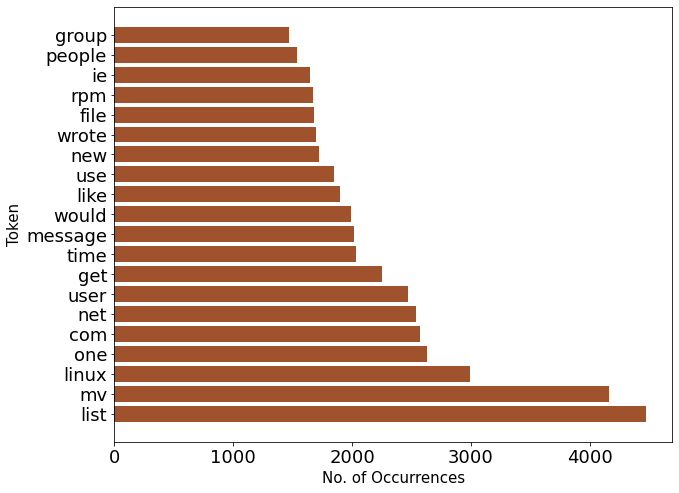

In [18]:
ns_dict = get_dict_and_count(ns_df)
ns_mostcommon = most_common(ns_dict)
ns_fig = visualize_barh(ns_mostcommon, name='Non-Spam')
ns_fig.savefig('ns_mostcommon.png')


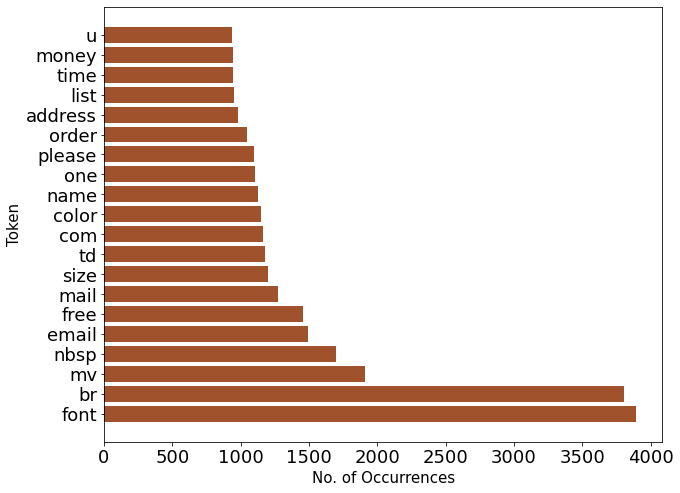

In [19]:
s_dict = get_dict_and_count(s_df)
s_mostcommon = most_common(s_dict)
s_fig = visualize_barh(s_mostcommon, name='Spam')
s_fig.savefig('s_mostcommon.png')

## Naive Bayes

In [20]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix, precision_score,recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [21]:
#load in data
data = pd.read_csv('all_data.txt', header=None, keep_default_na=False)
data = data.to_numpy()
X = data[:,0].astype('str')
y = data[:,1].astype('int')

In [22]:
'''TfidfVectorizer and CountVectorizer both are methods for converting text data 
into vectors as model can process only numerical data. In CountVectorizer we 
only count the number of times a word appears in the document which results in 
biasing in favour of most frequent words. this ends up in ignoring rare words 
which could have helped is in processing our data more efficiently.

To overcome this , we use TfidfVectorizer. In TfidfVectorizer we consider 
overall document weightage of a word. It helps us in dealing with most frequent 
words. Using it we can penalize them. TfidfVectorizer weights the word counts 
by a measure of how often they appear in the documents.'''

def perform_CV(X):
    CV_vect = CountVectorizer() #Convert a collection of text documents to a matrix of token counts
    X_CV = CV_vect.fit(X)
    X_CV = CV_vect.transform(X).toarray()    
    return X_CV


In [23]:
def perform_TFIDF(X):
    TFIDF_vect = TfidfVectorizer() #Convert a collection of text documents to a matrix of token counts
    X_TFIDF = TFIDF_vect.fit(X)
    X_TFIDF = TFIDF_vect.transform(X).toarray()    
    return X_TFIDF

In [24]:
def naive_bayes(X, y, title): #Gaussian Naive Bayes
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    
    NB_clf = GaussianNB()
    NB_clf.fit(X_train, y_train) #train
    NB_train_score = NB_clf.score(X_train, y_train) #get scoring strength
    
    NB_test_score = NB_clf.score(X_test, y_test)
    NB_predictions = NB_clf.predict(X_test)
    
    #moment of truth
    tn, fp, fn, tp = confusion_matrix(y_test,NB_predictions).ravel()
    precision = precision_score(y_test, NB_predictions)
    recall = recall_score(y_test, NB_predictions)
    f1score = f1_score(y_test, NB_predictions)
    print(title)
    print("Precision: {:.2f}%".format(100 * precision))
    print("Recall: {:.2f}%".format(100 * recall))
    print("F1 Score: {:.2f}%".format(100 * f1score))
    
    #graph confusion matrix
    labels =['Non-Spam', 'Spam']
    fig = plot_confusion_matrix(NB_clf, X_test, y_test, cmap=plt.cm.Blues, display_labels=labels) 
    #fig.ax_.set_title('Confusion Matrix - %s' %(title))
    
    save(NB_train_score, NB_test_score, tn, fp, fn, tp, precision, recall, f1score, title)
    

In [25]:
def save(NB_train_score, NB_test_score, tn, fp, fn, tp, precision, recall, f1score, title):
    NB_save = {'Type': ['NB_train_score', 'NB_test_score', 'TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'F1 Score'],
        'Value': [NB_train_score, NB_test_score, tn, fp, fn, tp, precision, recall, f1score]}
    NB_df = pd.DataFrame(NB_save, columns=['Type','Value'])
    NB_df.to_csv(title + '.txt', index=False)


Naive Bayes with CountVectorizer
Precision: 86.75%
Recall: 90.00%
F1 Score: 88.34%


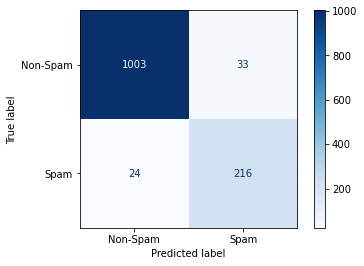

In [31]:
X_CV = perform_CV(X)
naive_bayes(X_CV,y,title='Naive Bayes with CountVectorizer')


Naive Bayes with TfidfVectorizer
Precision: 89.57%
Recall: 93.26%
F1 Score: 91.38%


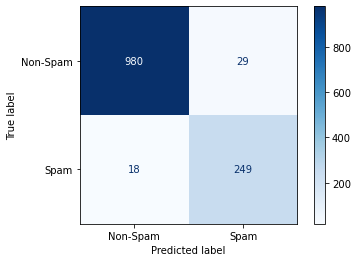

In [32]:
X_TFIDF = perform_TFIDF(X)
naive_bayes(X_TFIDF,y,title='Naive Bayes with TfidfVectorizer')

## Deep Learning

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score,recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional
import itertools


In [34]:
#load in data
data = pd.read_csv('all_data.txt', header=None, keep_default_na=False)
data = data.to_numpy()
X = data[:,0].astype('str')
y = data[:,1].astype('int')

In [35]:
#split data into training and test
X_train, X_test, y_train, y_test = train_test_split(X,y)


In [36]:
#pre hyperparameters
# file = 'glove.6B.300d.txt'
# def get_coefs(word,*arr): #from huai99
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file))

# all_embs = np.stack(embeddings_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
# embed_size = all_embs.shape[1]

embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a sentence to use
drop_val = 0.2
num_epochs = 30
max_words = 40000

In [37]:
# embed_size = 300 # how big is each word vector
# max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
# max_len = 2000 # max number of words in a sentence to use
# drop_val = 0.1
# num_epochs = 30
# max_words = 40000

# for i in X_train:
#     cur_len = len(i)
#     if cur_len > max_len:
#         max_len = cur_len

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

word_idx = tokenizer.word_index
tot_words = len(word_idx)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [38]:
#Dense Architecture
model = Sequential()
model.add(Embedding(input_dim=max_feature, output_dim=embed_size, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_val))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])
'''use ‘binary_crossentropy’ as a loss function because of binary output, 
‘adam’ as an optimiser which makes use of momentum to avoid local minima and 
‘accuracy’ as a measure of model performance.'''

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         5000000   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                2424      
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 5,002,449
Trainable params: 5,002,449
Non-trainable params: 0
______________________________________________

In [39]:
# early_stop = EarlyStopping(monitor='val_loss', patience=3)
#history = model.fit(X_train_pad, y_train, batch_size=512, epochs=num_epochs, validation_data=(X_test_pad, y_test), callbacks =[early_stop], verbose=2)
history = model.fit(X_train_pad, y_train, epochs=num_epochs, validation_data=(X_test_pad, y_test))
results  = model.evaluate(X_test_pad, y_test)


Epoch 1/30
120/120 [==============================] - 12s 89ms/step - loss: 0.5441 - accuracy: 0.7773 - val_loss: 0.4844 - val_accuracy: 0.8033
Epoch 2/30
120/120 [==============================] - 9s 76ms/step - loss: 0.4884 - accuracy: 0.7956 - val_loss: 0.4655 - val_accuracy: 0.8111
Epoch 3/30
120/120 [==============================] - 9s 79ms/step - loss: 0.4522 - accuracy: 0.8066 - val_loss: 0.4057 - val_accuracy: 0.8229
Epoch 4/30
120/120 [==============================] - 11s 90ms/step - loss: 0.3594 - accuracy: 0.8440 - val_loss: 0.2999 - val_accuracy: 0.8762
Epoch 5/30
120/120 [==============================] - 10s 83ms/step - loss: 0.2487 - accuracy: 0.9009 - val_loss: 0.2030 - val_accuracy: 0.9295
Epoch 6/30
120/120 [==============================] - 9s 78ms/step - loss: 0.1652 - accuracy: 0.9449 - val_loss: 0.1429 - val_accuracy: 0.9522
Epoch 7/30
120/120 [==============================] - 11s 92ms/step - loss: 0.1242 - accuracy: 0.9621 - val_loss: 0.1144 - val_accuracy: 0.

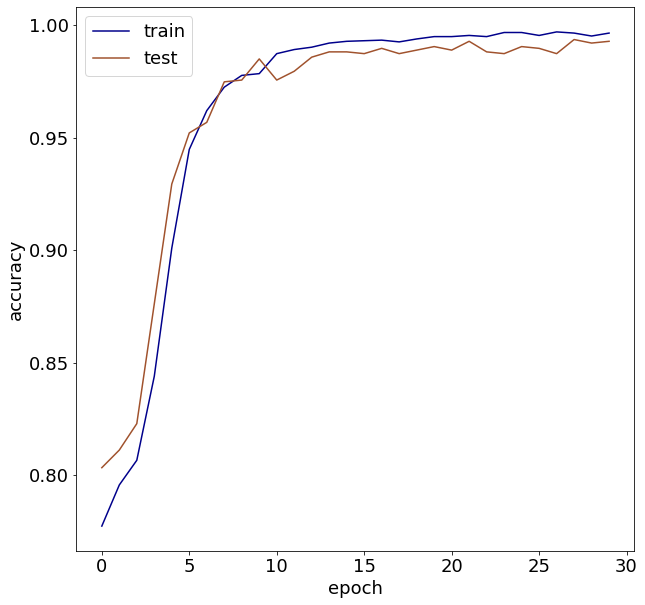

In [44]:
#plot
fig1 = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], color = 'darkblue')
plt.plot(history.history['val_accuracy'], color = 'sienna')
#plt.title('Model Accuracy')
plt.ylabel('accuracy', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(['train', 'test'], loc='best', fontsize=18)
plt.show()
fig1.savefig('DL_ModelAccuracy.png')



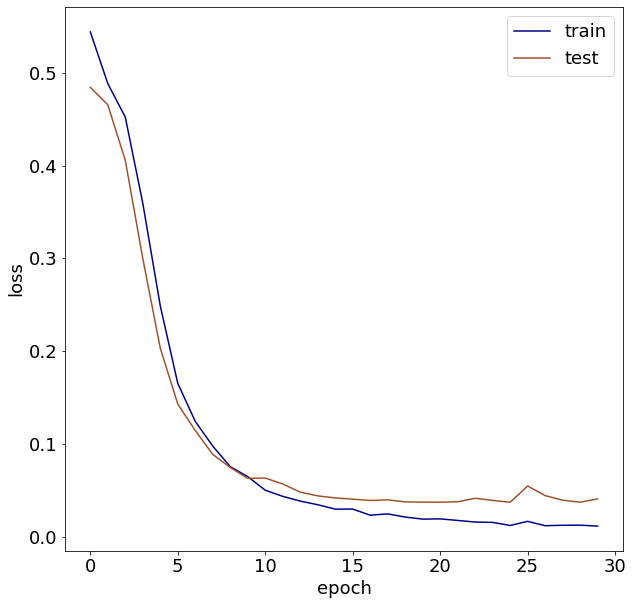

In [45]:

fig2 = plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], color = 'darkblue')
plt.plot(history.history['val_loss'], color = 'sienna')
#plt.title('Model Loss')
plt.ylabel('loss', fontsize=18)
plt.xlabel('epoch', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(['train', 'test'], loc='best', fontsize=18)
plt.show()
fig2.savefig('DL_ModelLoss.png')

In [41]:
# predict

DL_predictions = [1.0 if i > 0.5 else 0.0 for i in model.predict(X_test_pad)]

title = 'Deep Learning'
cm = confusion_matrix(y_test,DL_predictions)
tn, fp, fn, tp = confusion_matrix(y_test,DL_predictions).ravel()
precision = precision_score(y_test, DL_predictions)
recall = recall_score(y_test, DL_predictions)
f1score = f1_score(y_test, DL_predictions)


print(title)
print("Precision: {:.2f}%".format(100 * precision))
print("Recall: {:.2f}%".format(100 * recall))
print("F1 Score: {:.2f}%".format(100 * f1score))


40/40 [==============================] - 1s 22ms/step
Deep Learning
Precision: 98.04%
Recall: 98.43%
F1 Score: 98.23%


Confusion Matrix - Deep Learning
[[1017    5]
 [   4  250]]


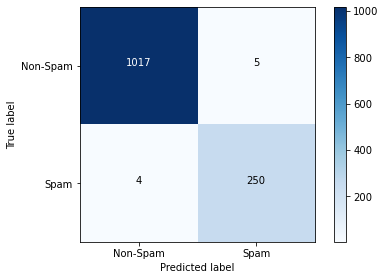

In [42]:
#graph confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=title,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Confusion Matrix - %s with Normalization' %(title))
    else:
        print('Confusion Matrix - %s' %(title))

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title('Confusion Matrix - %s' %(title))
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

labels =['Non-Spam', 'Spam']
plot_confusion_matrix(cm, labels) 

In [43]:
def save(tn, fp, fn, tp, precision, recall, f1score, title):
    NB_save = {'Type': ['TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'F1 Score'],
        'Value': [tn, fp, fn, tp, precision, recall, f1score]}
    NB_df = pd.DataFrame(NB_save, columns=['Type','Value'])
    NB_df.to_csv(title + 'results.txt', index=False)

save(tn, fp, fn, tp, precision, recall, f1score, title)